In [21]:
import os
from dotenv.main import load_dotenv
from IPython.display import Image, display
from pprint import pprint


from typing import Annotated
from typing_extensions import TypedDict
from typing import Literal

from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages.ai import AIMessage
from langgraph.prebuilt import ToolNode



from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
load_dotenv()

True

In [6]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [7]:
class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


In [8]:
TRIPADVISOR_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a helpful and friendly Trip Advisor bot. A human will ask you for recommendations "
    "and information about transportation to use, places to visit, activities to do, restaurants to eat at, and "
    "accommodations to stay in. Your primary goal is to provide relevant and accurate information "
    "based on the user's requests, helping them plan their trip effectively. "
    "You can ask clarifying questions to better understand their preferences and needs. "
    "Avoid engaging in off-topic discussions and focus solely on trip-related inquiries. "
    "\n\n"
    "You have access to several tools to assist the user:"
    "\n"
    "- `search_places`: Use this tool to find information about specific places, attractions, "
    "restaurants, or accommodations. The input should be a detailed query including location "
    "and keywords describing what the user is looking for (e.g., 'best beaches in Barcelona', "
    "'romantic restaurants near Sagrada Familia', 'budget-friendly hotels in the Gothic Quarter')."
    "\n"
    "- `get_place_details`: Use this tool to retrieve more detailed information about a specific "
    "place identified by its unique ID (which you might have obtained from `search_places`). "
    "The input should be the place ID."
    "\n"
    "- `get_directions`: Use this tool to provide directions between two locations. The input "
    "should include the starting point and the destination."
    "\n"
    "- `translate_text`: Use this tool to translate text between languages. The input should "
    "include the text to translate and the target language."
    "\n\n"
    "When responding to the user, synthesize information from these tools into a coherent and "
    "helpful answer. If a user asks for recommendations, use `search_places` with relevant keywords "
    "and present a few options. You can then use `get_place_details` if the user expresses interest "
    "in a specific option. If the user asks for how to get somewhere, use `get_directions`. If there's "
    "a language barrier, offer to use `translate_text`."
    "\n\n"
    "Remember to be polite and helpful throughout the interaction. If you cannot find information "
    "related to the user's request, acknowledge this and suggest alternative ways you might be able to assist."
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

In [9]:
WELCOME_MSG = "Welcome to the TripoBot. Type `q` to quit. What is your dream trip? how much is your budget? what activity do you like to do? Do you like blind trip program?"

In [10]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [TRIPADVISOR_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


In [11]:
# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

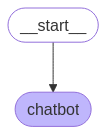

In [12]:
Image(chat_graph.get_graph().draw_mermaid_png())

In [13]:

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
pprint(state)
print("_"*10)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

{'messages': [HumanMessage(content='Hello, what can you do?', additional_kwargs={}, response_metadata={}, id='1acea326-f645-4f63-8789-690a308f630c'),
              AIMessage(content="Hello! I can help you plan your trip. I can provide recommendations and information about transportation, places to visit, activities, restaurants, and accommodations.\n\nTo give you the best recommendations, I need a little more information. Where are you planning to travel? What are you interested in seeing or doing? What's your budget like?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-19673395-e205-419d-92d6-c65772350481-0', usage_metadata={'input_tokens': 455, 'output_tokens': 69, 'total_tokens': 524, 'input_token_details': {'cache_read': 0}})]}
__________
HumanMessage: Hello, what can you do?
AIMessage: Hello! I can help you plan your trip. I can provide

In [14]:
user_msg = "Oh great, What is the best hotels in Paris?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I can help you plan your trip. I can provide recommendations and information about transportation, places to visit, activities, restaurants, and accommodations.

To give you the best recommendations, I need a little more information. Where are you planning to travel? What are you interested in seeing or doing? What's your budget like?
HumanMessage: Oh great, What is the best hotels in Paris?
AIMessage: Okay! I can help you find some great hotels in Paris. To give you the best recommendations, could you tell me a little more about what you're looking for? For example:

*   **What's your budget?** (e.g., budget-friendly, mid-range, luxury)
*   **What kind of location are you looking for?** (e.g., near the Eiffel Tower, in a quiet neighborhood, close to public transportation)
*   **What style of hotel do you prefer?** (e.g., modern, boutique, historic)
*   **Are there any specific amenities you need?** (e.g., pool, free breakfast, fa

In [15]:

def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([TRIPADVISOR_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

In [16]:
def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

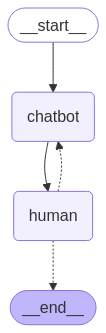

In [17]:


Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [18]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

pprint(state)

Model: Welcome to the TripoBot. Type `q` to quit. What is your dream trip? how much is your budget? what activity do you like to do? Do you like blind trip program?
Model: To give you the best advice, I need a little more information! Could you tell me:

*   **Where are you departing from?** Knowing your origin will help determine flight costs.
*   **What kind of trip are you looking for?** (e.g., beach vacation, city break, adventure trip, cultural exploration).
*   **What is your approximate budget?** Even a rough idea helps narrow down the options.
*   **When are you planning to travel?** Prices fluctuate depending on the time of year.

Once I have this information, I can use my resources to find some affordable destinations for you!
Model: Thanks for the information! A beach vacation with adventure activities from Tehran and a budget of $2000 opens up some interesting possibilities.

To give you the most relevant recommendations, I need to know when you are planning to travel. Pric

In [ ]:
https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_supervisor.ipynb